# UQ for an Optical Potential!

One of the main motivations for building an emulator is to rapidly evaluate posteriors for Bayesian optimization and uncertainty-quantification. Often, our models have high dimensional parameter spaces, and are expensive to solve, making these analyzis computationally prohibitive. In this tutorial, we will use an emulator from `ROSE`, combined with the Bayesian optimization package `surmise`, which uses Markov-chain Monte Carlo (MCMC) to find the best fit values on the parameters space.



We will use the emulator with optimal configuration we found in the previous tutorial, with 7 basis elements and 7 terms in the affine decomposition: 

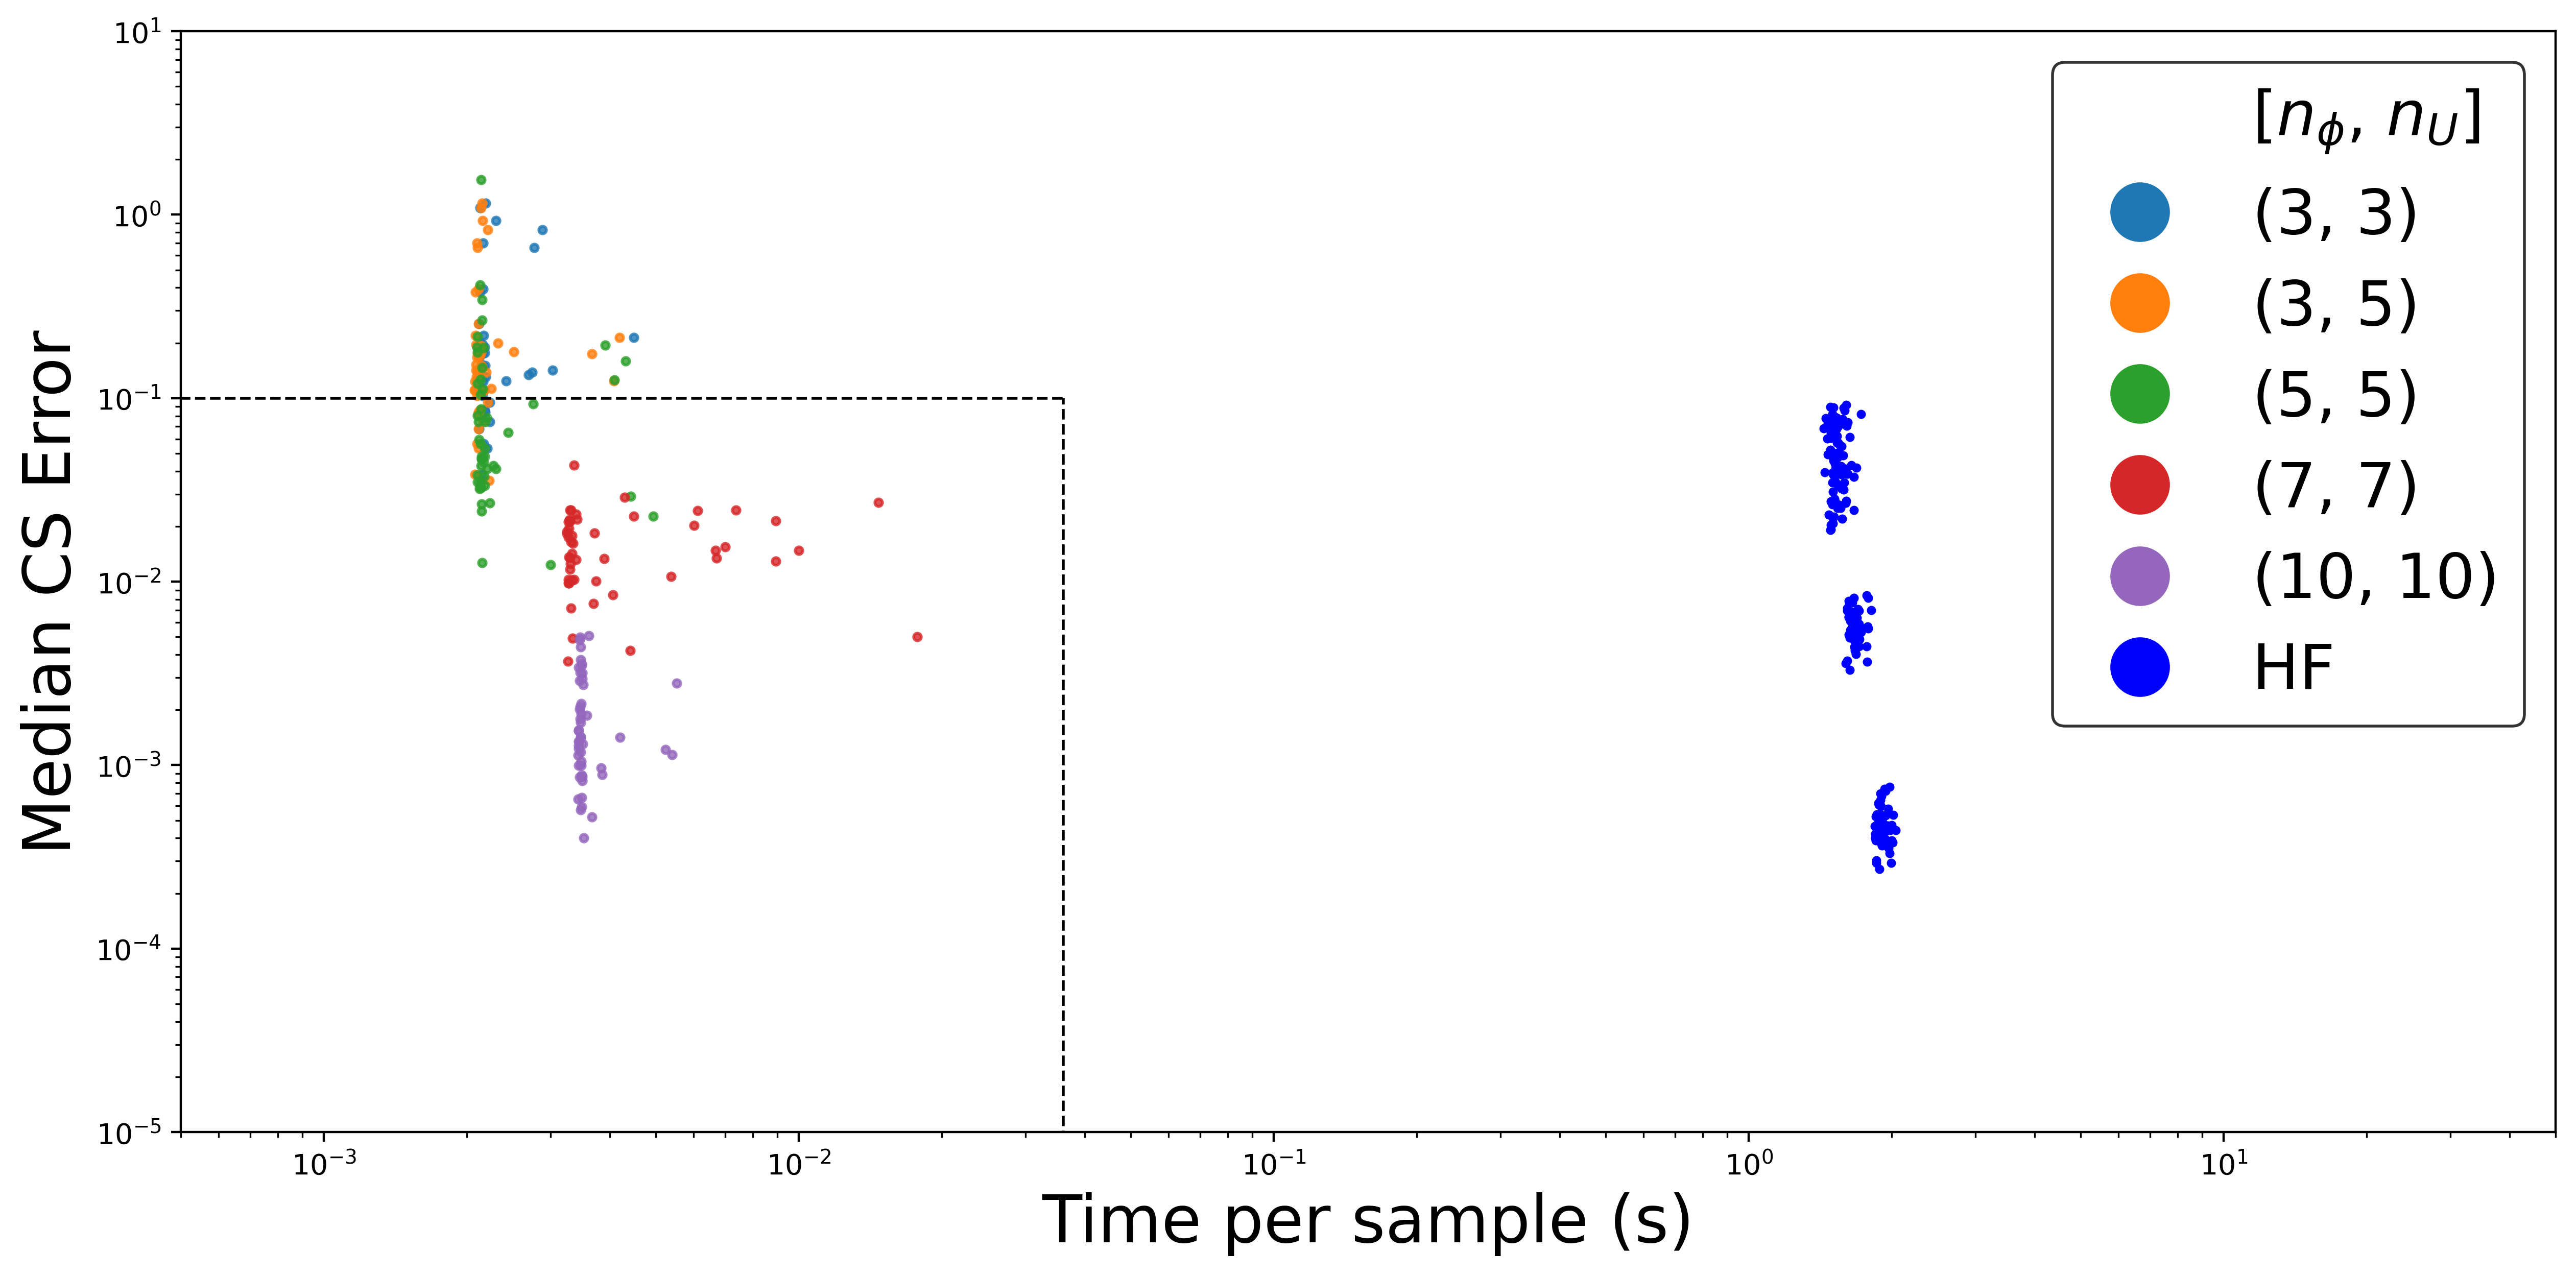

We see that the median of our emulator error was around 10^-2 and we will use that as a rough estimate of the expected error. Be mindful that, when selecting the emulator configuration (7,7) we used 50 test samples from a box of $20\%$ in the parameter space, and we expect that if our random walkers get to far from this training region the emulator quality will decrease.


First we quickly create our emulator, copying the problem setup from the previous tutorial:

In [1]:
# import ROSE to construct the emulator
# !pip install nuclear-rose=='0.9.4a0'
import rose

# other nice things
import numpy as np
import time
import os
from scipy.stats import qmc

# import stuff for nice plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as sps
from tqdm import tqdm
import seaborn as sns
import random
import datetime

# !pip install corner
import corner


plt.rcParams.update({"font.size": 12})

In [2]:
print(rose.__version__)

0.9.7.dev12+g8ec385d.d20230926


In [3]:
A = 40  # mass of the target

AMU = 931.494102  # MeV/c^2, Particle Data Group
MASS_N = 1.008665 * AMU  # MeV/c^2 PDG
MASS_P = 1.007276 * AMU  # MeV/c^2 PDG
MASS_CHARGED_PION = 139.57039  # MeV/c^2
B_40CA = 342.0522  # BMEX

MASS_40CA = 20 * MASS_P + 20 * MASS_N - B_40CA
MU = (
    MASS_40CA * MASS_N / (MASS_40CA + MASS_N)
)  # reduced mass - we will do calculations in COM frame

# asymptotic energy and wavenumber in center-of-mass (COM) frame
energy = 14.1  # MeV
k = np.sqrt(2 * MU * energy) / rose.constants.HBARC

# how many partial waves should we calculate?
l_max = 10
l_list = list(range(l_max + 1))

# domain of the differential cross section; the observable we want to emulate
angles = np.linspace(1, 179, 179)
# ROSE also has a convenient grid over radial space we can steal
rho = rose.constants.DEFAULT_RHO_MESH.copy()

In [4]:
# shape of interaction for volume term
def wood_saxon(r, R, a):
    return 1 / (1 + np.exp((r - R) / a))


# shape of interaction for surface-peaked and spin-orbit coupling terms
def wood_saxon_prime(r, R, a):
    return -1 / a * np.exp((r - R) / a) / (1 + np.exp((r - R) / a)) ** 2


# total potential with a real and central term (with the same geometry)
# and imaginary surface-peaked term, but no SO coupling
def optical_potential(r, theta):
    Vv, Wv, Wd, Vso, Wso, Rv, Rd, Rso, av, ad, aso = theta
    return (1j * Wv - Vv) * wood_saxon(r, Rv, av) - (4j * ad * Wd) * wood_saxon_prime(
        r, Rd, ad
    )


# spin orbit interaction constant
mso = rose.constants.HBARC / MASS_CHARGED_PION


# spin-orbit (SO) coulpling term - a function of l dot s, l being the orbital angular momentum
# and s being the spin of the neutron
def spin_orbit_potential(r, theta, ldots):
    Vv, Wv, Wd, Vso, Wso, Rv, Rd, Rso, av, ad, aso = theta
    return (Vso + 1j * Wso) * mso**2 * ldots * wood_saxon_prime(r, Rso, aso) / r


# the total number of parameters
nparams = 11

In [5]:
# This is the value of the parameters coming from the Koning-Delaroche parametrization.
# Taken from https://www-nds.iaea.org/RIPL-3/
VvKD = 46.7238
WvKD = 1.72334
WdKD = -7.2357
VsoKD = 6.1
WsoKD = -3.1

RvKD = 4.0538
RdKD = 4.4055
RsoKD = 1.01 * 40 ** (1.0 / 3.0)

avKD = 0.6718
adKD = 0.5379
asoKD = 0.60

alphaCentral = np.array(
    [VvKD, WvKD, WdKD, VsoKD, WsoKD, RvKD, RdKD, RsoKD, avKD, adKD, asoKD]
)

scaleTraining = 0.2

bounds = np.array(
    [
        alphaCentral - np.fabs(alphaCentral * scaleTraining),
        alphaCentral + np.fabs(alphaCentral * scaleTraining),
    ]
).T


def sample_points(npoints, bounds, initial_seed=None):
    sampler = qmc.LatinHypercube(d=len(bounds), seed=initial_seed)
    sample = sampler.random(npoints)
    scaled = qmc.scale(sample, bounds[:, 0], bounds[:, 1])
    return scaled

Great, we have our potential and parameters set up. Before we create our emulator, let's take a look at the experimental data we want to fit.

## Experimental data for neutron scattering on $^{40}$ Ca

Let's consider the practical example of fitting an optical potential to a differential elastic scattering cross section measurement. In particular, we will use [this measurement](http://dx.doi.org/10.1016/0029-5582(64)90087-2) from 1964 by McDonald and Robson, available [here on Exfor](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=207&subID=11611003&plus=1).


This was a measurement of 14 MeV neutrons incident on a $^{40}$ Ca target. The outgoing neutrons - also at 14 MeV, remember, this is an elastic reaction - were then measured in one of an array of detectors, each set up a different scattering angle relative to the incident beam. From the density of the target and the incident flux of the beam, the authors reconstructed $\frac{d\sigma}{d\theta}$, the scattering cross section differentiated on the scattering angle (in the center-of-mass frame). Let's first take a look at this data, and then we'll talk about how to find the best-fit parameters and their uncertainties.



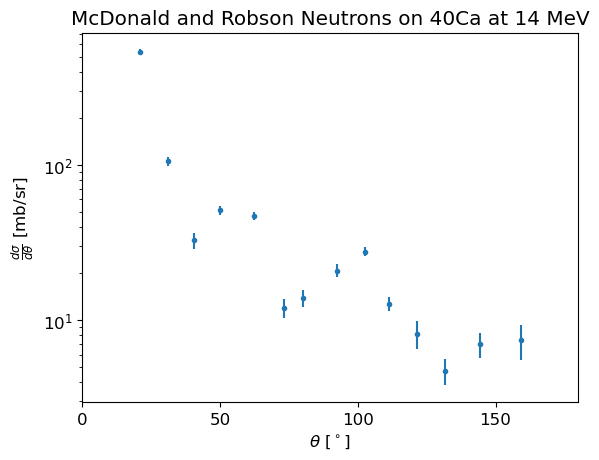

In [6]:
# Angles where d xs / s theta was measured, in degrees, 0 being transmission, 180 being reflection back to the beamline

cos_theta = np.array(
    [
        0.93420,
        0.85630,
        0.76150,
        # 0.75470,  This particular measurement seems to be miss-transcribed in the data set. I replaced by the one below (41 deg to 51 deg)
        0.64279,
        0.46640,
        0.28740,
        0.17360,
        -0.0419,
        -0.2181,
        -0.3616,
        -0.5240,
        -0.6665,
        -0.8141,
        -0.9342,
    ]
)

anglesX = np.array(
    [np.arccos(cos_theta[i]) / np.pi * 180 for i in range(len(cos_theta))]
)


# corresponding experimental cross sections
dxs = np.array(
    [
        5.34e02,
        1.06e02,
        3.27e01,
        5.10e01,
        4.69e01,
        1.20e01,
        1.39e01,
        2.09e01,
        2.77e01,
        1.28e01,
        8.2e00,
        4.7e00,
        7.0e00,
        7.4e00,
    ]
)

# experimental error
dxs_err = np.array(
    [
        2.3e01,
        7.0e0,
        4.0e0,
        3.5e0,
        2.9e0,
        1.7e0,
        1.7e0,
        2.0e0,
        1.8e0,
        1.4e0,
        1.7e0,
        9.0e-01,
        1.3e0,
        1.9e0,
    ]
)

angular_resolution = 11  # degrees

plt.yscale("log")
# plt.errorbar(anglesX, dxs, dxs_err, xerr=angular_resolution, linestyle="none", marker=".")
plt.errorbar(anglesX, dxs, dxs_err, linestyle="none", marker=".")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
plt.ylabel(r"$\frac{d \sigma}{d \theta}$ [mb/sr]")
plt.title("McDonald and Robson Neutrons on 40Ca at 14 MeV")

plt.rc("xtick", labelsize=15)  # fontsize of the tick labels
plt.rc("ytick", labelsize=15)

plt.show()

We will build our emulator to predict the CS over the fine grid of angles so we can have relatively continous plots in the end, but we need to be sure that when calibrating with the data, the ROSE emulator is predicting only on the 14 actual points of data.

In [7]:
n_basis = 7
n_eim = 7

interactions = rose.InteractionEIMSpace(
    optical_potential,
    nparams,
    MU,
    energy,
    l_max,
    is_complex=True,
    spin_orbit_potential=spin_orbit_potential,
    training_info=bounds,
    n_basis=n_eim,
)

In [8]:
n_train = 50
seed_train = 142857
training_samples = sample_points(n_train, bounds, initial_seed=seed_train)

saeMCMC_fullangles = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    training_samples,
    l_max,
    n_basis=n_basis,
    angles=angles / 180 * np.pi,
    hf_tols=[
        10 ** (-9),
        10 ** (-9),
    ],
)

100%|███████████████████████████████████████████| 11/11 [01:15<00:00,  6.84s/it]
/home/kyle/umich/rose/src/rose/utility.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  return np.hstack([1/(2*s_c) * (3 - (s[ii]/s_c)**2), 1/s[jj]])


## Specifying the Prior

In [9]:
# In this default we are assuming uncorrelated Gaussian priors. Advanced users can provide covariance matrices for correlations

# Specifying the priors, we believe the answer that explains the data shouldn't be too far away from the KD parameters
alphaCentralPrior = alphaCentral

# We are using Gaussian priors with a standard deviation of 15% of their respective centers
SigmasPrior = [abs(param_val * 0.15) for param_val in alphaCentralPrior]

# We use a smaller scale for the starting values of the MCMC chains so that we minimize the chances of one
# starting in a negative value of the diffuseness or the radii

# This scale is very important: since the optical potential posterior parameter surface is highly multimodal we would like to limit ourself for this tutorial
# to study a vicinity of the main mode closer to our prior. We will start our walkers very close to the prior center.
MCMCScale = [abs(param_val * 0.01) for param_val in alphaCentralPrior]

# This error scale comes from the CAT plot we showed at the begining. The factor of 5 is to be overly conservative and reduce the chance of under-estimation
Emulator_Error = 5 * 10 ** (-2)

## Going Bayesian with Surmise

We will use surmise, another BAND-developed package for connecting all the tools and softwares (such as our ROSE emulator) for performing Bayesian analysis.

Check out surmise's documentation webpage for more information: https://surmise.readthedocs.io/en/latest/

In [10]:
# Be sure to install this version of surmise

!pip install surmise

In [11]:
# check for surmise-0.2.1.dev14
import surmise
import importlib

importlib.reload(surmise)
print(surmise.__version__)

0.2.0


Our sample rate for the emulator is around 3 miliseconds, which means around 20k samples per minute. We are choosing a relatively small amount of samples and chains to have the calibration done in a couple of minutes. You can of course run it for longer and obtain millions of samples to build very detailed and rich corner plots.

In [12]:
from surmise.emulation import emulator
from surmise.calibration import calibrator

X = np.copy(anglesX) / 180 * np.pi
y = np.copy(dxs)  # data we want to fit
yerr = np.copy(dxs_err)  # err in data

StepSizes0 = 0.01 * np.abs(alphaCentral)

numsamp = 5000
total_chains = 5
numcores = 8
BurnSamples0 = 500

In [13]:
class prior_scattering:
    """This defines the class instance of priors provided to the method."""

    def lpdf(theta):
        total_prior_pdf = sps.norm.logpdf(
            theta[:, 0], alphaCentralPrior[0], SigmasPrior[0]
        )

        for i in range(1, len(alphaCentralPrior)):
            total_prior_pdf = total_prior_pdf + sps.norm.logpdf(
                theta[:, i], alphaCentralPrior[i], SigmasPrior[i]
            )

        return (total_prior_pdf).reshape((len(theta), 1))

    def rnd(n):
        totalRandomSamples = []
        for i in range(len(alphaCentralPrior)):
            totalRandomSamples.append(
                sps.norm.rvs(alphaCentralPrior[i], MCMCScale[i], size=n)
            )

        totalRandomSamplesNumpy = np.array(totalRandomSamples)

        return totalRandomSamplesNumpy.T


def calibration_runner(rbm, x, y, obsvar, test_params, numsamp, i, caldir):
    cal = calibrator(
        emu=rbm,
        y=y,
        x=x,
        thetaprior=prior_scattering,
        method="directbayes",
        yvar=obsvar,
        args={
            "theta0": test_params.reshape(1, nparams),
            "sampler": "metropolis_hastings",
            "numsamp": numsamp,
            "stepType": "normal",
            "stepParam": StepSizes0,
            "burnSamples": BurnSamples0,
            "verbose": True,
        },
    )

    calfile = os.path.join(caldir, "caltheta_{}.out".format(i))
    np.savetxt(calfile, cal.info["thetarnd"])

    return cal.info["thetarnd"]

In [14]:
random.seed(142857)

obsvar = 1.0 * np.square(yerr)

caldir = os.path.join(
    os.getcwd(), "Cal-" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
)
os.makedirs(caldir, exist_ok=True)

rand_params = prior_scattering.rnd(total_chains)

In [15]:
rbm = emulator(
    method="nuclear-ROSE",
    args={
        "rose_emu": saeMCMC_fullangles,
        "emu_variance_constant": Emulator_Error,
        "angle_atol": 1e-1,
    },
)
st = time.time()
sep_chains = []
chain0 = calibration_runner(rbm, X, y, obsvar, rand_params[0], numsamp, 0, caldir)
sep_chains.append(chain0)
all_chains = chain0

for ij in tqdm(range(total_chains - 1)):
    current_cal = calibration_runner(
        rbm, X, y, obsvar, rand_params[ij], numsamp, ij + 1, caldir
    )

    all_chains = np.vstack(
        (
            all_chains,
            current_cal,
        )
    )

    sep_chains.append(current_cal)

    print("Percentage Completed ", int((ij + 1) / (total_chains - 1) * 100))

sep_chains = np.array(sep_chains)
et = time.time()
print("Total time:", et - st)

Final Acceptance Rate:  0.2892


 25%|███████████▎                                 | 1/4 [00:57<02:51, 57.08s/it]

Final Acceptance Rate:  0.2874
Percentage Completed  25


 50%|██████████████████████▌                      | 2/4 [01:43<01:41, 50.84s/it]

Final Acceptance Rate:  0.289
Percentage Completed  50


 75%|█████████████████████████████████▊           | 3/4 [02:27<00:47, 47.66s/it]

Final Acceptance Rate:  0.3002
Percentage Completed  75


100%|█████████████████████████████████████████████| 4/4 [03:29<00:00, 52.38s/it]

Final Acceptance Rate:  0.2902
Percentage Completed  100
Total time: 261.86819410324097


In [16]:
# Getting the same number of samples from the prior so we can compare the two
samples_prior = []
for i in range(len(alphaCentralPrior)):
    samples_prior.append(
        sps.norm.rvs(alphaCentralPrior[i], SigmasPrior[i], size=100000)
    )

samples_prior = np.array(samples_prior).T

## Plotting the results of the calibration

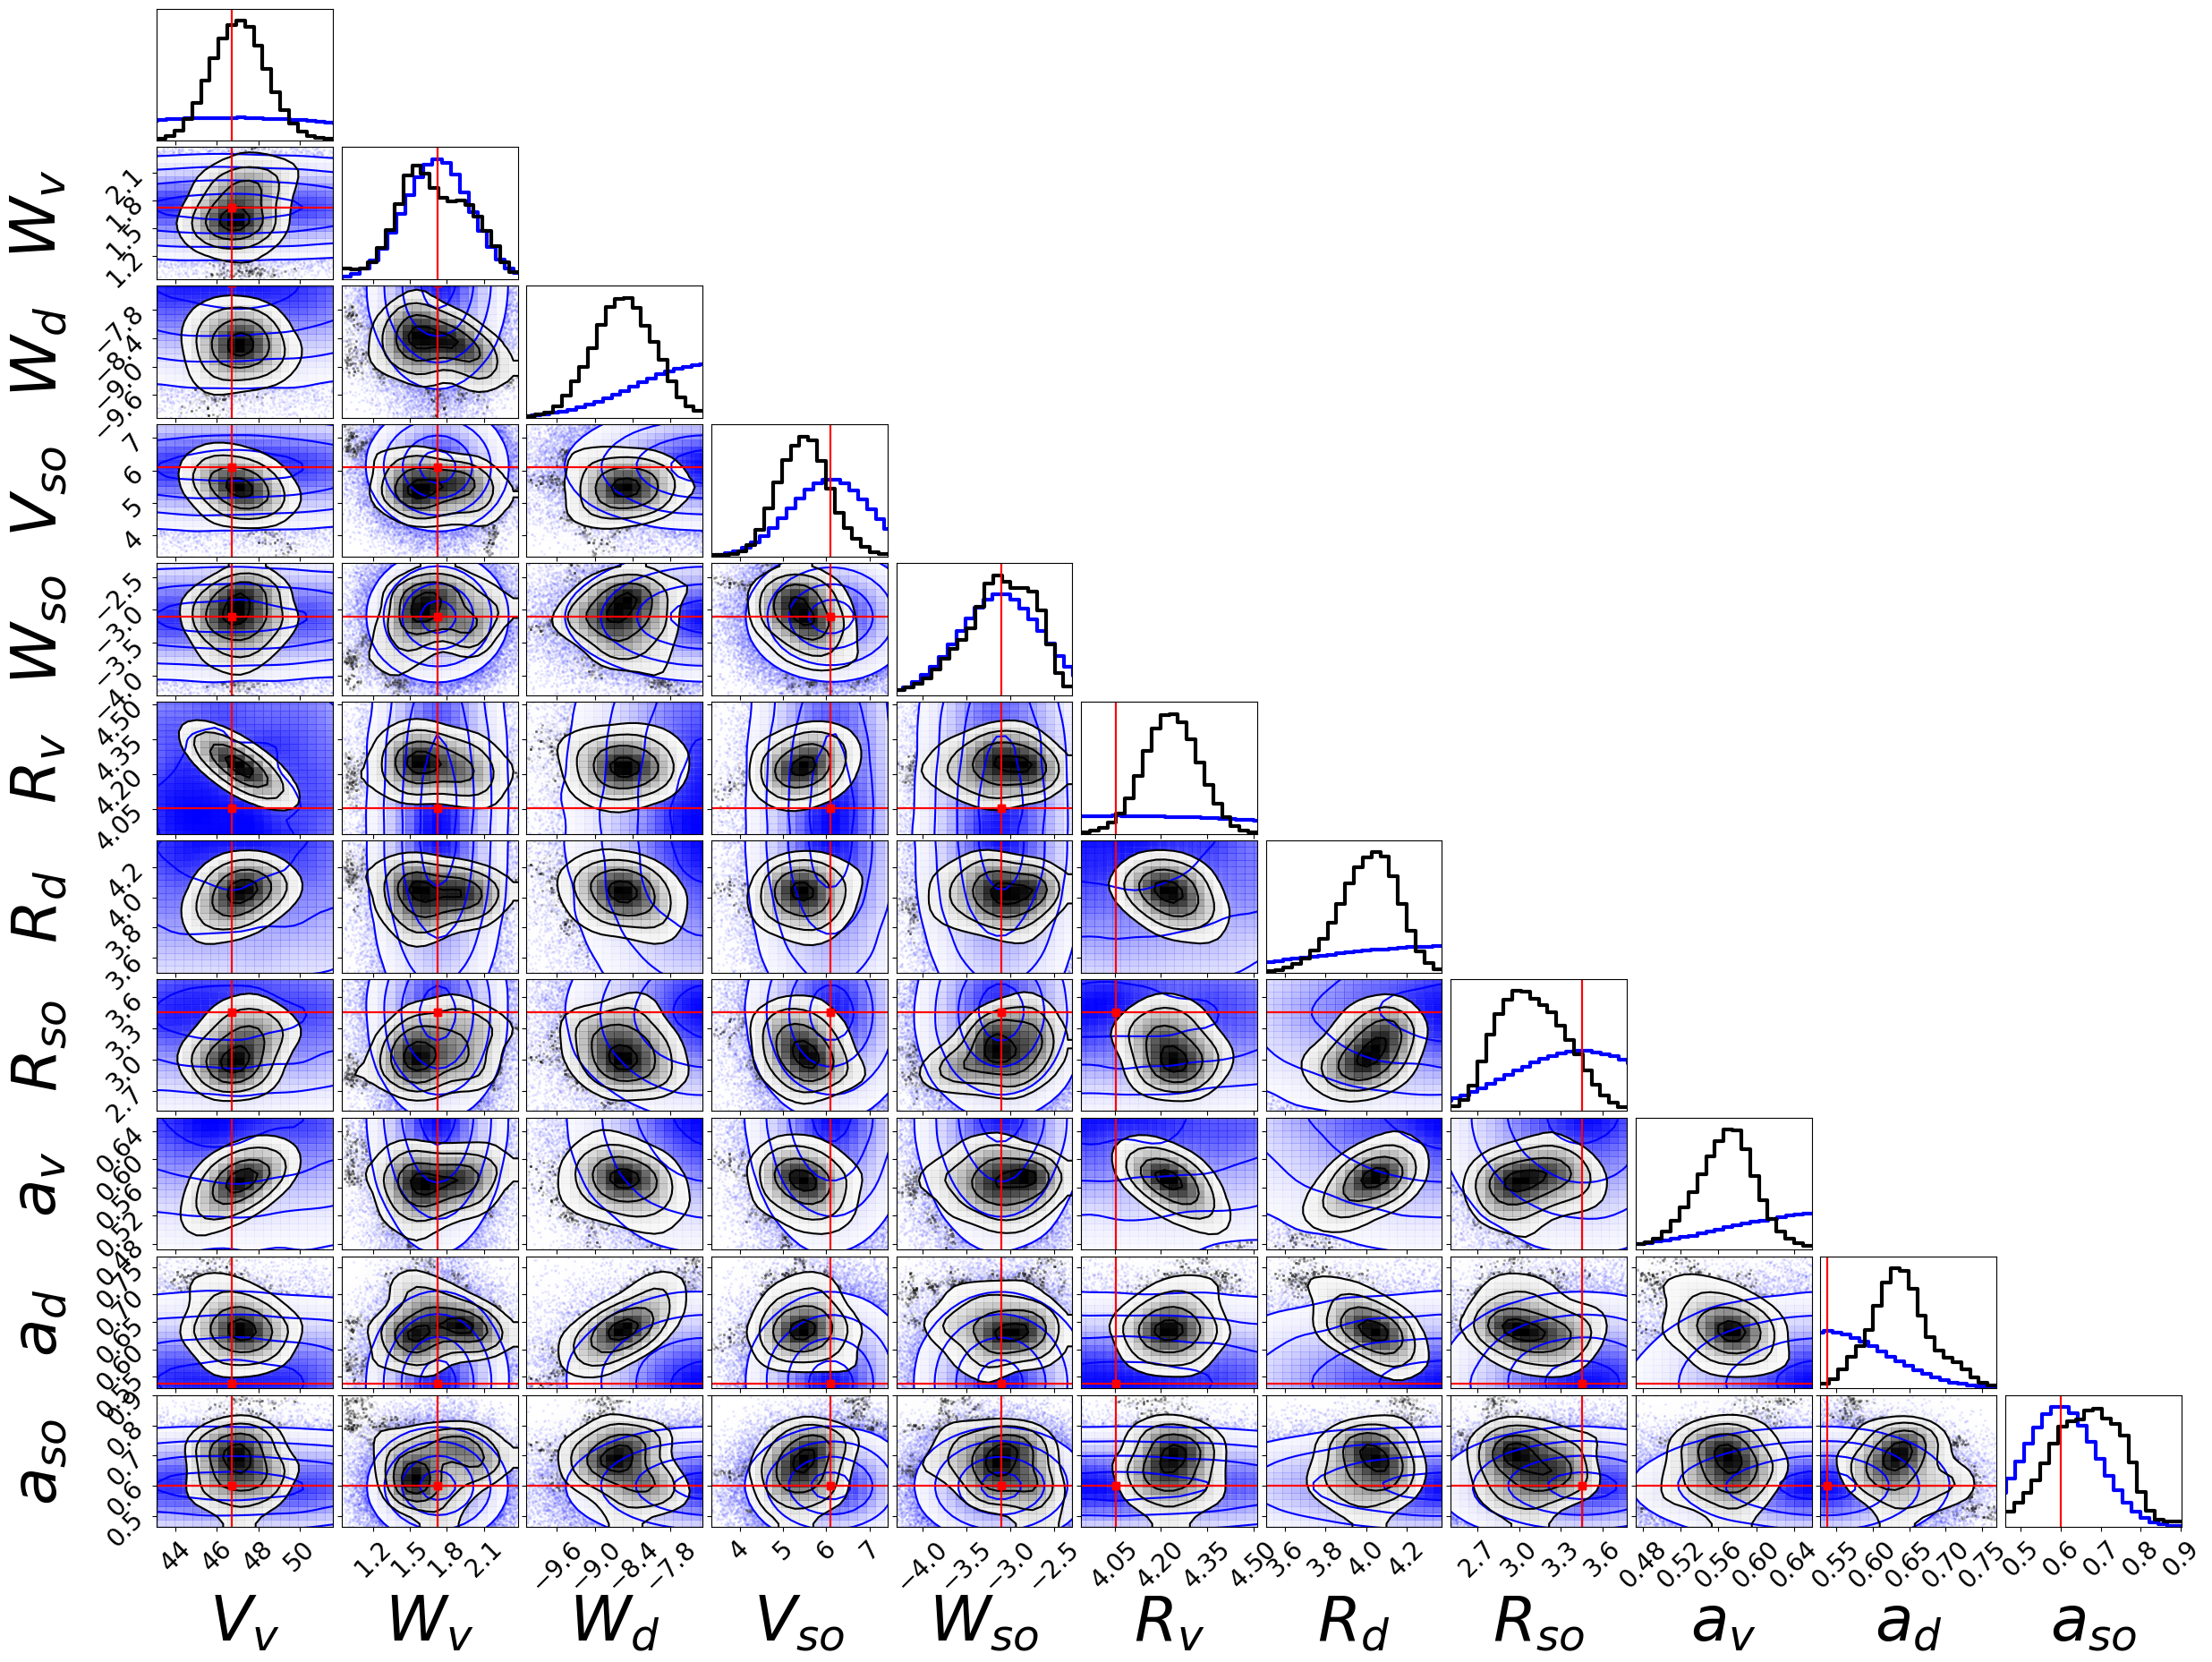

In [17]:
# The plotting routinge to make the gorgeous corner plots! For some reason we have to run it twice to make the label
# size for the ticks to be correct

plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

bins_target = 20
ws = [
    abs(max(all_chains[:, i]) - min(all_chains[:, i])) / bins_target
    for i in range(len(all_chains.T))
]

figure = corner.corner(
    samples_prior,
    labels=[
        "$V_v$",
        "$W_v$",
        "$W_d$",
        "$V_{so}$",
        "$W_{so}$",
        "$R_v$",
        "$R_d$",
        "$R_{so}$",
        "$a_v$",
        "$a_d$",
        "$a_{so}$",
    ],
    labelpad=0.2,
    weights=np.full(len(samples_prior), (len(all_chains)) / (len(samples_prior))),
    bins=[
        int(abs(max(samples_prior[:, i]) - min(samples_prior[:, i])) / ws[i])
        for i in range(len(samples_prior.T))
    ],
    color="b",
    # bins=20,
    label_kwargs={"fontsize": 50},
    hist_kwargs={"linewidth": 3},
    quantiles=None,
    truths=alphaCentral,
    truth_color="r",
    smooth=(1.7),
    smooth1d=1.0,
)


corner.corner(
    all_chains,
    fig=figure,
    labels=[
        "$V_v$",
        "$W_v$",
        "$W_d$",
        "$V_{so}$",
        "$W_{so}$",
        "$R_v$",
        "$R_d$",
        "$R_{so}$",
        "$a_v$",
        "$a_d$",
        "$a_{so}$",
    ],
    labelpad=0.2,
    # bins=20,
    bins=[
        int(abs(max(all_chains[:, i]) - min(all_chains[:, i])) / ws[i])
        for i in range(len(all_chains.T))
    ],
    label_kwargs={"fontsize": 50},
    hist_kwargs={"linewidth": 3},
    quantiles=None,
    truths=alphaCentral,
    truth_color="r",
    smooth=(1.7),
    smooth1d=1.0,
)


dim = len(all_chains[0])
ranges = [
    [min(all_chains[:, i]), max(all_chains[:, i])] for i in range(len(all_chains.T))
]

axes = np.array(figure.axes).reshape((dim, dim))
# print()
for i in range(dim):
    ax = axes[i, i]
    ax.set_xlim(ranges[i][0], ranges[i][1])

    for j in range(i):
        ax = axes[i, j]
        ax.set_ylim(ranges[i][0], ranges[i][1])
        ax.set_xlim(ranges[j][0], ranges[j][1])


width = 24
height = 18
figure.set_size_inches(width, height)

plt.show()

Very interesting! In red we can see the original parametrization by Koning-Delaroche that we used as the center of our prior, the blue lines are the actual prior, and the black ones the posterior. Most parameters are more or less around that value, while some shifted appreciably.Some parameters are very well constrained by the data, while others seem to just be constrained by the prior. 

Thanks to ROSE, we now can make these kinds of analysis VERY fast!

In [18]:
labelsChains = [
    "$V_v$",
    "$W_v$",
    "$W_d$",
    "$V_{so}$",
    "$W_{so}$",
    "$R_v$",
    "$R_d$",
    "$R_{so}$",
    "$a_v$",
    "$a_d$",
    "$a_{so}$",
]

Below we plot the parameters that all the chains, concatenated together, explored. The horizontal red lines are the KD values

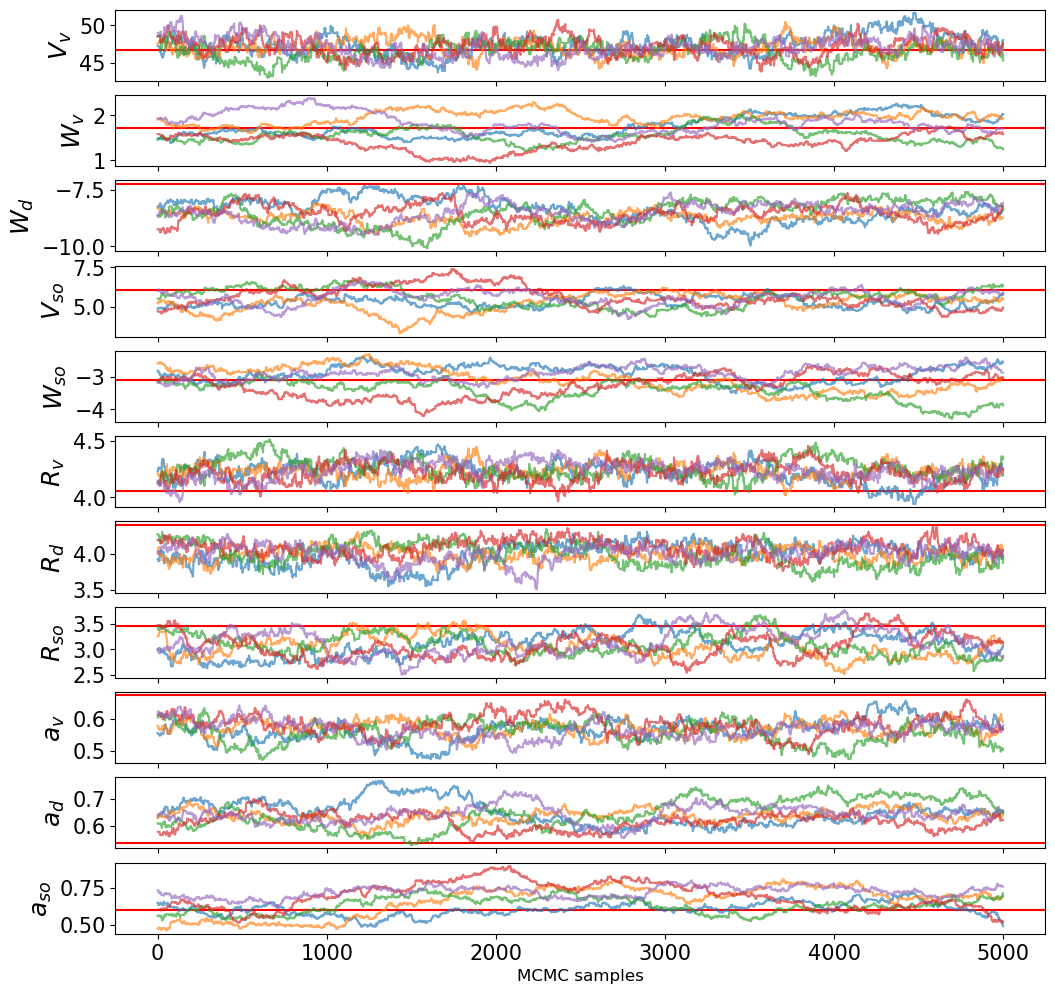

In [19]:
XAll = np.arange(len(anglesX))

plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
fig, axs = plt.subplots(nparams, 1, figsize=(12, 12), sharex="all")

for i in range(nparams):
    axs[i].axhline(y=alphaCentral[i], color="r")
    axs[i].plot(sep_chains[:, :, i].T, alpha=0.65)
    axs[i].set_ylabel(labelsChains[i], fontsize=18)

plt.xlabel("MCMC samples")
plt.show()

## Plotting our final calibrated model alongside the data

In [20]:
XAll = np.arange(len(anglesX))

In [21]:
# %#%time
rng = np.random.default_rng()
theta_rand = rng.choice(all_chains, (1000), replace=False)

In [22]:
rndm_m = np.array(
    [saeMCMC_fullangles.emulate_dsdo(theta_rand[i]) for i in range(len(theta_rand))]
)

In [23]:
# rndm_m = rbm(XAll, theta_rand).mean().T

In [24]:
KD_cs = saeMCMC_fullangles.emulate_dsdo(alphaCentral)

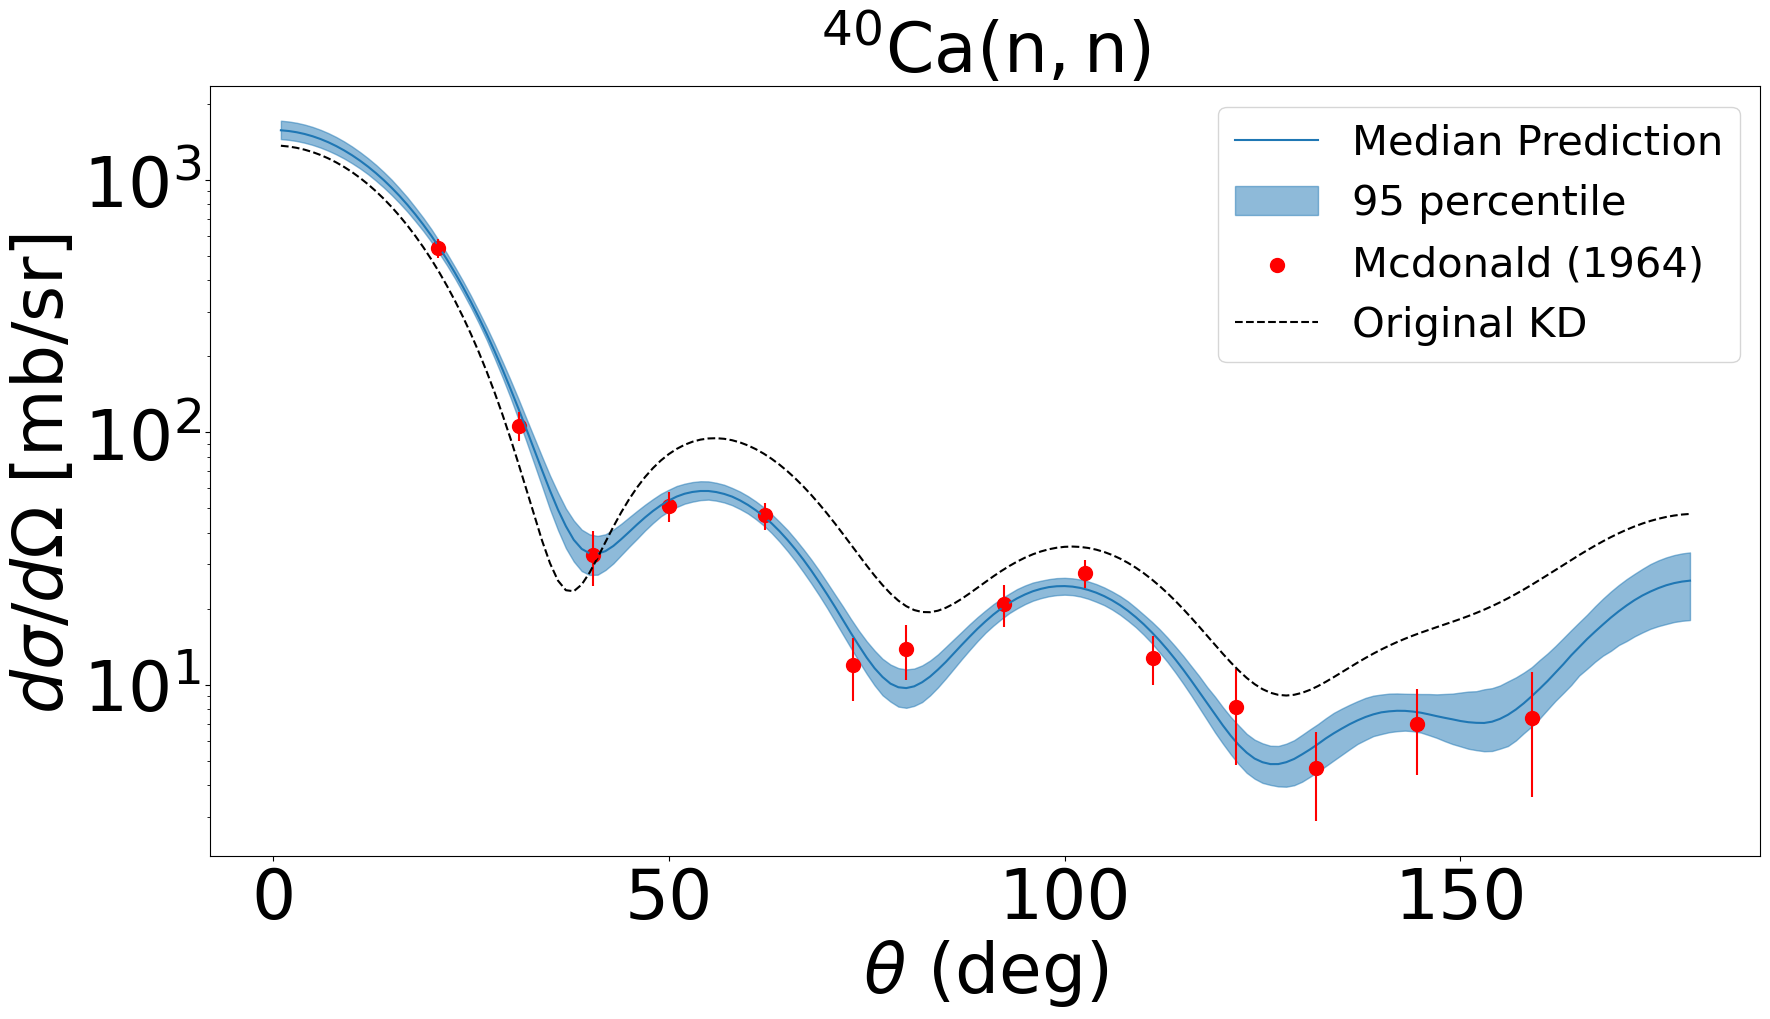

In [25]:
plt.rc("xtick", labelsize=50)  # fontsize of the tick labels
plt.rc("ytick", labelsize=50)

fig, axs = plt.subplots(1, 1, figsize=(20, 10))
median = np.percentile(rndm_m, 50, axis=0)
upper = np.abs(np.percentile(rndm_m, 97.5, axis=0))


lower = np.abs(np.percentile(rndm_m, 2.5, axis=0))

axs.plot(angles, median, color="C0", label="Median Prediction")
axs.fill_between(angles, lower, upper, color="C0", alpha=0.5, label="95 percentile")

axs.scatter(anglesX, y, s=100, c="r", label="Mcdonald (1964)")
axs.errorbar(anglesX, y, yerr=2 * yerr, fmt="o", c="r")

axs.set_yscale("log")

axs.set_xlabel(r"$\theta$ (deg)", fontsize=50)
axs.set_ylabel(r"$d\sigma/d\Omega$ [mb/sr] ", fontsize=50)

axs.plot(angles, KD_cs, c="k", linestyle="dashed", label="Original KD")


plt.title(r"$^{40}\rm{Ca}(n,n)$", fontsize=50)


plt.legend(fontsize="30")
plt.show()

And we are done! This is trully a Bayesian calibration of our Optical potential and, as we can see, it really learned something from the data. Compare the black dashed line, the original KD global parametrization, with the median and 95% confidence intervals of our calibrated model. 

Now the power is yours, go ahead on many adventures and calibrate many reaction models with all the available data. 

                                                                                                                                The ROSE team
